# Importing libraries

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Data preprocessing

In [64]:
training_set = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
training_set['Open-Close'] = training_set.Open - training_set.Close
training_set['High-Low'] = training_set.High - training_set.Low
training_set = training_set.dropna()
training_set_classes = np.where(training_set['Close'].shift(-1) > training_set['Close'], 1, 0)


test_set = yf.download('AAPL', start='2020-01-01', end='2022-01-01')
test_set['Open-Close'] = test_set.Open - test_set.Close
test_set['High-Low'] = test_set.High - test_set.Low
test_set = test_set.dropna()
test_set_classes = np.where(test_set['Close'].shift(-1) > test_set['Close'], 1, 0)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In the case of SVM-s, we have to rewrite the problem in the form of a classification exercise. Luckily with stocks, we can do this easily by doing binary classification based on the relative change of prices

Price,Close,High,Low,Open,Volume,Open-Close,High-Low
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000
mean,25.193720,25.410615,24.959997,25.187015,2.995931e+08,-0.006705,0.450618
std,13.949579,14.051678,13.826204,13.929082,2.352800e+08,0.338591,0.359771
min,5.779476,5.898345,5.725308,5.789106,4.544800e+07,-2.115677,0.037918
25%,13.828139,13.971870,13.714396,13.860777,1.247008e+08,-0.159227,0.216264
50%,22.312837,22.485251,22.125462,22.280718,2.218420e+08,-0.007513,0.342714
75%,35.304037,35.714798,34.962632,35.345779,4.067637e+08,0.144973,0.568722
max,71.093987,71.171444,70.094094,70.481445,1.880998e+09,2.162993,3.784631


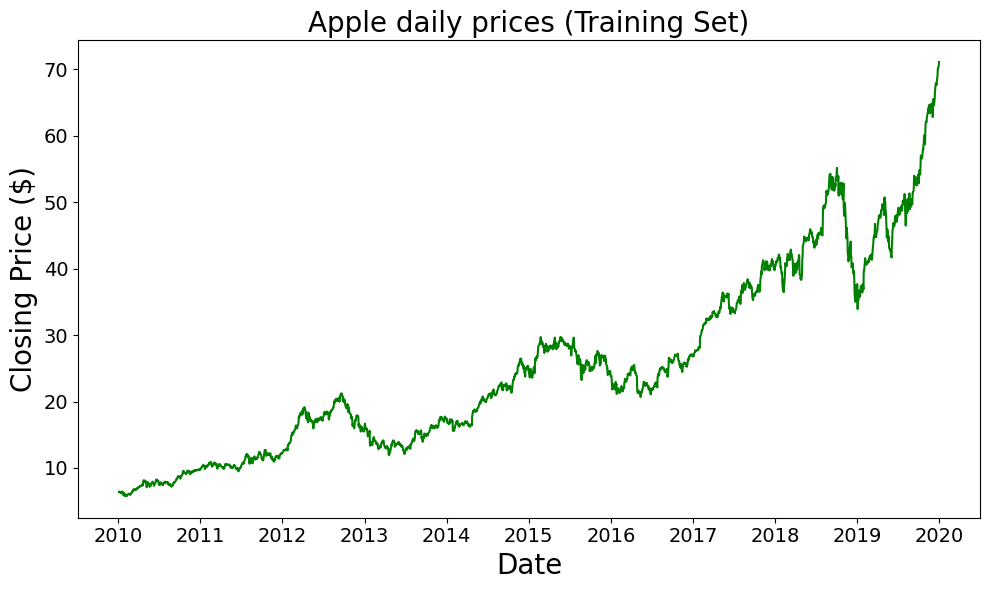

In [65]:
plt.figure(figsize=(10,6))
plt.plot(
  training_set.index,
  training_set['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices (Training Set)", fontsize=20)
plt.tight_layout()
training_set.describe()

In [66]:
training_set.head()

Price,Close,High,Low,Open,Volume,Open-Close,High-Low
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2010-01-04,6.440330,6.455075,6.391277,6.422875,493729600,-0.017454,0.063798
2010-01-05,6.451467,6.487880,6.417460,6.458087,601904800,0.006621,0.070419
2010-01-06,6.348846,6.477045,6.342225,6.451465,552160000,0.102619,0.134820
2010-01-07,6.337109,6.379842,6.291066,6.372319,477131200,0.035210,0.088777
2010-01-08,6.379240,6.379842,6.291368,6.328683,447610800,-0.050557,0.088475


# Scaling

In [67]:
svm_train = training_set[['Open-Close', 'High-Low']].copy(deep=True)
svm_test = test_set[['Open-Close', 'High-Low']].copy(deep=True)

# scaler = MinMaxScaler()
# svm_train = scaler.fit_transform(svm_train) # Only fit scaler to training set
# svm_test = scaler.transform(svm_test)


# svm_train = pd.DataFrame(svm_train, columns=['Open-Close', 'High-Low'])
# svm_test = pd.DataFrame(svm_test, columns=['Open-Close', 'High-Low'])
# svm_train.head()
# #svm_test.head()

# Fitting a model

In [68]:
svm = SVC(kernel='linear') # For simplicity, we will use a linear kernel, but in real life you should use a non-linear kernel
svm.fit(svm_train, training_set_classes.ravel())

training_set['Predict'] = svm.predict(svm_train)
training_set['Return'] = training_set['Close'].pct_change()
training_set['Strategy_Return'] = training_set['Return'] * training_set['Predict'].shift(1)

training_set['Cum_Ret'] = training_set['Return'].cumsum()
training_set['Cum_Strategy'] = training_set['Strategy_Return'].cumsum()

training_set

Price,Close,High,Low,Open,Volume,Open-Close,High-Low,Predict,Return,Strategy_Return,Cum_Ret,Cum_Strategy
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
Date,,,,,,,,,,,,
2010-01-04,6.440330,6.455075,6.391277,6.422875,493729600,-0.017454,0.063798,1,NaN,NaN,NaN,NaN
2010-01-05,6.451467,6.487880,6.417460,6.458087,601904800,0.006621,0.070419,1,0.001729,0.001729,0.001729,0.001729
2010-01-06,6.348846,6.477045,6.342225,6.451465,552160000,0.102619,0.134820,1,-0.015907,-0.015907,-0.014177,-0.014177
2010-01-07,6.337109,6.379842,6.291066,6.372319,477131200,0.035210,0.088777,1,-0.001849,-0.001849,-0.016026,-0.016026
2010-01-08,6.379240,6.379842,6.291368,6.328683,447610800,-0.050557,0.088475,1,0.006648,0.006648,-0.009378,-0.009378
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,68.823021,68.973132,68.496186,68.924708,48478800,0.101687,0.476946,1,0.000951,0.000951,2.701163,2.701163
2019-12-26,70.188507,70.205456,68.927145,68.956196,93121200,-1.232311,1.278311,1,0.019841,0.019841,2.721004,2.721004


In [60]:
training_set['Cum_Strategy']

Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
              ..
2019-12-24   NaN
2019-12-26   NaN
2019-12-27   NaN
2019-12-30   NaN
2019-12-31   NaN
Name: Cum_Strategy, Length: 2516, dtype: float64

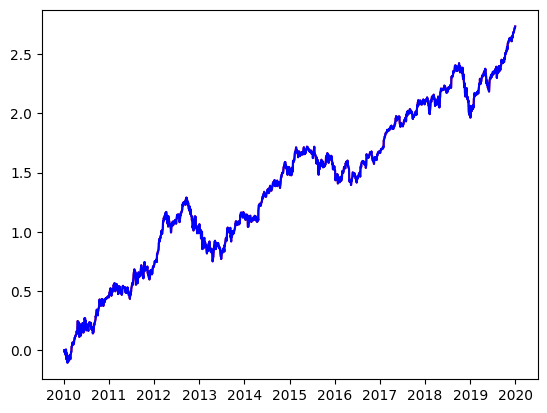

In [53]:
plt.plot(training_set['Cum_Ret'],color='red')
plt.plot(training_set['Cum_Strategy'],color='blue')

In [61]:
training_set['Predict']

Date
2010-01-04    1
2010-01-05    1
2010-01-06    1
2010-01-07    1
2010-01-08    1
             ..
2019-12-24    1
2019-12-26    1
2019-12-27    1
2019-12-30    1
2019-12-31    1
Name: Predict, Length: 2516, dtype: int64

In [69]:
training_set['Predict'].value_counts()

Predict
1    2516
Name: count, dtype: int64